# How to advance your Bloomberg experience throw utilising Python and Machine Learning

# Part C: Machine Learning

In [1]:
# Import Bloomberg API
#from xbbg import blp

# Import required libraries
import pandas as pd; print (pd.__version__ )
import numpy as np; print (np.__version__ )

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import hashlib
import os

# Import necessary modules
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Keras specific
import tensorflow as tf

from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import SimpleRNN, Bidirectional, BatchNormalization, Embedding, LSTM, Dense, GRU, Conv1D, GlobalMaxPool1D, MaxPool1D, MaxPooling1D, Dropout, Activation , Flatten , Input, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import backend as K

1.0.5
1.18.5


In [2]:
tickers = "AAPL US Equity"
commands = "PX_LAST, PX_HIGH, PX_LOW, PX_VOLUME, TWITTER_SENTIMENT, TWITTER_NEG_SENTIMENT_COUNT, TWITTER_POS_SENTIMENT_COUNT, TWITTER_NEUTRAL_SENTIMENT_CNT, TWITTER_PUBLICATION_COUNT"

start = '2016-07-26'
end = '2021-07-26'

filename = hashlib.md5(''.join((tickers,"+",
          commands,"+",
          start,"+",
          end)).encode('utf-8')).hexdigest()

if os.path.exists(filename+'.csv'):
    data = pd.read_csv(filename+".csv", header=[0, 1],
    parse_dates=True,
    index_col=0)
else:
    data = blp.bdh(tickers=tickers.split(', ') , flds=commands.split(', '), start_date=start,  end_date=end,Per='D', Fill='P', Days='A', adjust='all')
    data.to_csv(filename+".csv")
    
df = data['AAPL US Equity']
df

,PX_LAST,PX_HIGH,PX_LOW,PX_VOLUME,TWITTER_NEG_SENTIMENT_COUNT,TWITTER_POS_SENTIMENT_COUNT,TWITTER_NEUTRAL_SENTIMENT_CNT,TWITTER_PUBLICATION_COUNT
2016-07-26,22.577,22.881,22.519,224959288.0,944.0,575.0,6051.0,8482.0
2016-07-27,24.044,24.371,23.997,369379280.0,5913.0,3793.0,15074.0,27091.0
2016-07-28,24.368,24.394,24.013,159479356.0,1057.0,2828.0,8466.0,14479.0
2016-07-29,24.338,24.417,24.214,110934752.0,451.0,591.0,6703.0,8809.0
2016-07-30,24.338,24.417,24.214,110934752.0,451.0,591.0,6703.0,8809.0
...,...,...,...,...,...,...,...,...
2021-07-22,146.800,148.195,145.810,77338156.0,14.0,9.0,360.0,1630.0
2021-07-23,148.560,148.718,146.920,71447416.0,10.0,21.0,344.0,1749.0
2021-07-24,148.560,148.718,146.920,71447416.0,10.0,21.0,344.0,1749.0
2021-07-25,148.560,148.718,146.920,71447416.0,10.0,21.0,344.0,1749.0


In [3]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset.loc[:, 'ma7'] = dataset['PX_LAST'].rolling(window=7).mean()
    dataset.loc[:, 'ma21'] = dataset['PX_LAST'].rolling(window=21).mean()
    # Create MACD
    dataset.loc[:, '26ema'] = dataset['PX_LAST'].ewm(span=26).mean()
    dataset.loc[:, '12ema'] = dataset['PX_LAST'].ewm(span=12).mean()
    dataset.loc[:, 'MACD'] = (dataset['12ema']-dataset['26ema'])
    # Create Bollinger Bands
    dataset.loc[:, '20sd'] = dataset['PX_LAST'].rolling(20).std()
    dataset.loc[:, 'upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset.loc[:, 'lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    # Create Exponential moving average
    dataset.loc[:, 'ema'] = dataset['PX_LAST'].ewm(com=0.5).mean()
    # Create Momentum
    dataset.loc[:, 'momentum'] = dataset['PX_LAST']-1
    return dataset

ti_df = get_technical_indicators(df[['PX_LAST']].copy()).fillna(method='bfill')
ti_df.index = pd.DatetimeIndex(df.index)
ti_df

,PX_LAST,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2016-07-26,22.577,24.110143,24.860238,22.577000,22.577000,0.000000,0.716661,25.890056,23.830420,22.577000,21.577
2016-07-27,24.044,24.110143,24.860238,23.338712,23.371625,0.032913,0.716661,25.890056,23.830420,23.677250,23.044
2016-07-28,24.368,24.110143,24.860238,23.708525,23.760510,0.051986,0.716661,25.890056,23.830420,24.155462,23.368
2016-07-29,24.338,24.110143,24.860238,23.884499,23.942801,0.058303,0.716661,25.890056,23.830420,24.278675,23.338
2016-07-30,24.338,24.110143,24.860238,23.989667,24.050175,0.060508,0.716661,25.890056,23.830420,24.318388,23.338
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-22,146.800,145.710000,144.416190,142.541676,145.316874,2.775198,2.643875,149.703940,139.128441,146.329135,145.800
2021-07-23,148.560,146.020000,144.825714,142.987478,145.815817,2.828339,2.540147,149.906008,139.745420,147.816378,147.560
2021-07-24,148.560,146.330000,145.235238,143.400257,146.237999,2.837741,2.350608,149.936454,140.534023,148.312126,147.560
2021-07-25,148.560,146.640000,145.644762,143.782460,146.595230,2.812769,2.051610,149.747982,141.541542,148.477375,147.560


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-07-26 to 2021-07-26
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PX_LAST                        1827 non-null   float64
 1   PX_HIGH                        1827 non-null   float64
 2   PX_LOW                         1827 non-null   float64
 3   PX_VOLUME                      1827 non-null   float64
 4   TWITTER_NEG_SENTIMENT_COUNT    1827 non-null   float64
 5   TWITTER_POS_SENTIMENT_COUNT    1827 non-null   float64
 6   TWITTER_NEUTRAL_SENTIMENT_CNT  1827 non-null   float64
 7   TWITTER_PUBLICATION_COUNT      1827 non-null   float64
dtypes: float64(8)
memory usage: 128.5 KB


In [5]:
target_column = ['PX_LAST']
predictors = list(set(list(df.columns))-set(target_column))

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(df[predictors])
y = scaler.fit_transform(df[target_column])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 123,shuffle=False)    
split_time = X_train.shape[0]

X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1644, 1, 7) (1644, 1) (183, 1, 7) (183, 1)


In [7]:
def create_lstm(X_train, regress=False):
    model = Sequential()
    model.add(LSTM(units = 32,activation='relu',return_sequences=True,input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128,return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 512))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    return model

modelName = "./LSTM"
if not os.path.exists(modelName+"/model.h5"):
    model_lstm = create_lstm(X_train, regress=False)
    model_lstm.compile(loss = 'mae', optimizer = 'adam')
    history_lstm = model_lstm.fit(X_train, y_train, epochs = 100,batch_size=32, validation_data = (X_test, y_test), shuffle=False)
    scores_lstm = model_lstm.evaluate(X_train, y_train, verbose=0)
    model_lstm.save(modelName)
    # serialize weights to HDF5
    model_lstm.save_weights(modelName+"/model.h5")
else:   
    model_lstm = load_model(modelName)
    model_lstm.load_weights(modelName+'/model.h5')
    model_lstm.compile(loss = 'mae', optimizer = 'adam')
    scores_lstm = model_lstm.evaluate(X_train, y_train, verbose=0)
    
print(model_lstm.summary())
print('')

Epoch 1/100
52/52 [==============================] - 3s 51ms/step - loss: 0.0794 - val_loss: 0.1492
Epoch 2/100
52/52 [==============================] - 1s 23ms/step - loss: 0.2604 - val_loss: 0.3949
Epoch 3/100
52/52 [==============================] - 1s 23ms/step - loss: 0.1227 - val_loss: 0.1015
Epoch 4/100
52/52 [==============================] - 1s 24ms/step - loss: 0.1264 - val_loss: 0.0521
Epoch 5/100
52/52 [==============================] - 1s 23ms/step - loss: 0.0827 - val_loss: 0.0116
Epoch 6/100
52/52 [==============================] - 1s 24ms/step - loss: 0.0477 - val_loss: 0.0358
Epoch 7/100
52/52 [==============================] - 1s 26ms/step - loss: 0.0330 - val_loss: 0.0090
Epoch 8/100
52/52 [==============================] - 1s 25ms/step - loss: 0.0352 - val_loss: 0.0106
Epoch 9/100
52/52 [==============================] - 1s 21ms/step - loss: 0.0253 - val_loss: 0.0201
Epoch 10/100
52/52 [==============================] - 1s 21ms/step - loss: 0.0357 - val_loss: 0.0088

Epoch 82/100
52/52 [==============================] - 1s 19ms/step - loss: 0.0233 - val_loss: 0.0689
Epoch 83/100
52/52 [==============================] - 1s 19ms/step - loss: 0.0274 - val_loss: 0.0941
Epoch 84/100
52/52 [==============================] - 1s 19ms/step - loss: 0.0232 - val_loss: 0.0619
Epoch 85/100
52/52 [==============================] - 1s 19ms/step - loss: 0.0245 - val_loss: 0.0215
Epoch 86/100
52/52 [==============================] - 1s 24ms/step - loss: 0.0216 - val_loss: 0.0259
Epoch 87/100
52/52 [==============================] - 1s 23ms/step - loss: 0.0224 - val_loss: 0.0302
Epoch 88/100
52/52 [==============================] - 1s 26ms/step - loss: 0.0253 - val_loss: 0.0282
Epoch 89/100
52/52 [==============================] - 1s 22ms/step - loss: 0.0214 - val_loss: 0.0275
Epoch 90/100
52/52 [==============================] - 1s 28ms/step - loss: 0.0183 - val_loss: 0.0277
Epoch 91/100
52/52 [==============================] - 1s 26ms/step - loss: 0.0209 - val_los

In [8]:
def create_gru(X_train, regress=False):
    model = Sequential()
    model.add(GRU(units = 32,activation='relu',return_sequences=True,input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units = 128,return_sequences = True))
    model.add(Dropout(0.2))
    model.add(GRU(units = 512))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    return model

modelName = "./GRU"
if not os.path.exists(modelName+"/model.h5"):
    model_gru = create_gru(X_train, regress=False)
    model_gru.compile(loss = 'mae', optimizer = 'adam')
    history_gru = model_gru.fit(X_train, y_train, epochs = 15,batch_size=32, validation_data = (X_test, y_test), shuffle=False)
    scores_gru = model_gru.evaluate(X_train, y_train, verbose=0)
    model_gru.save(modelName)
    # serialize weights to HDF5
    model_gru.save_weights(modelName+"/model.h5")
else:    
    model_gru = load_model(modelName)
    model_gru.load_weights(modelName+'/model.h5')
    results_gru = model_gru.compile(loss = 'mae', optimizer = 'adam')
    history_gru = model_gru.fit(X_train, y_train, epochs = 15,batch_size=32, validation_data = (X_test, y_test), shuffle=False)
    scores_gru= model_gru.evaluate(X_train, y_train, verbose=0)

print(model_gru.summary())
print('')

Epoch 1/15
52/52 [==============================] - 2s 38ms/step - loss: 0.0620 - val_loss: 0.0852
Epoch 2/15
52/52 [==============================] - 1s 14ms/step - loss: 0.1427 - val_loss: 0.1486
Epoch 3/15
52/52 [==============================] - 1s 14ms/step - loss: 0.2098 - val_loss: 0.0774
Epoch 4/15
52/52 [==============================] - 1s 14ms/step - loss: 0.1147 - val_loss: 0.0121
Epoch 5/15
52/52 [==============================] - 1s 16ms/step - loss: 0.0414 - val_loss: 0.0286
Epoch 6/15
52/52 [==============================] - 1s 15ms/step - loss: 0.0359 - val_loss: 0.0295
Epoch 7/15
52/52 [==============================] - 1s 14ms/step - loss: 0.0369 - val_loss: 0.0126
Epoch 8/15
52/52 [==============================] - 1s 15ms/step - loss: 0.0429 - val_loss: 0.0126
Epoch 9/15
52/52 [==============================] - 1s 14ms/step - loss: 0.0376 - val_loss: 0.0141
Epoch 10/15
52/52 [==============================] - 1s 14ms/step - loss: 0.0383 - val_loss: 0.0323
Epoch 11/

# Part D: Virtualization

In [9]:
color1 = "#522dc2"
color2 = "#daeb6c"
color3 = "#c4c4be"

dfname = "Apple Inc"

# Data frame for metrics
metricsDF = pd.DataFrame(columns=['MSE', 'MAE'])

#Functions to evaluate results and save metrics
def evalModel(forecast):
    mse = tf.keras.metrics.mean_squared_error(y_test.values.reshape(-1), forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(y_test.values.reshape(-1), forecast).numpy()
    return mse, mae

def addMetrics(metricsDF, modelName, forecast):
    metricsDF.loc[modelName] = list(evalModel(forecast))
    return metricsDF

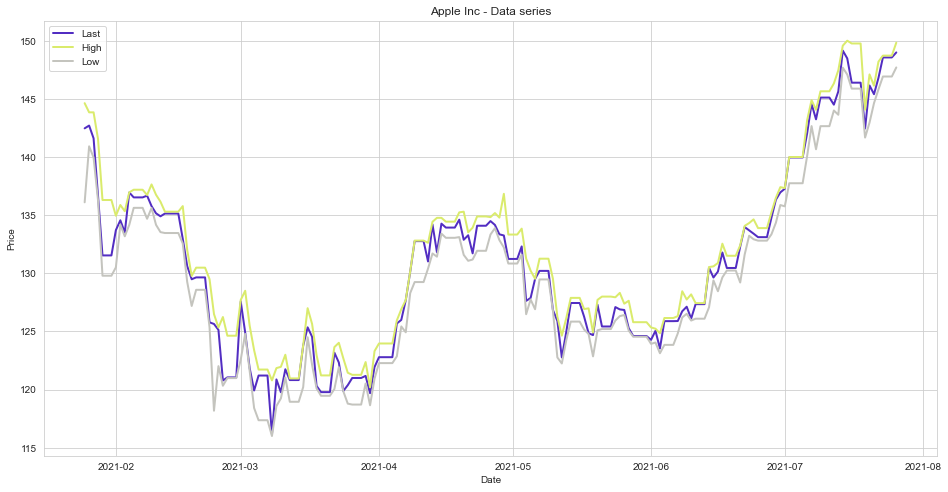

In [10]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df['PX_LAST'][split_time:], lw=2, c=color1)
plt.plot(df['PX_HIGH'][split_time:], lw=2, c=color2)
plt.plot(df['PX_LOW'][split_time:], lw=2, c=color3)
plt.legend(['Last','High', 'Low'])

plt.title(dfname + ' - Data series')
plt.grid(True)
plt.show()

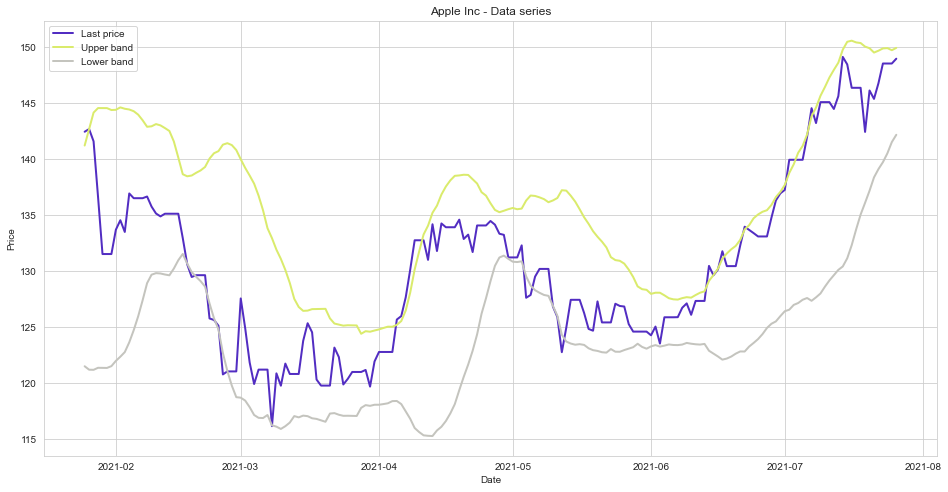

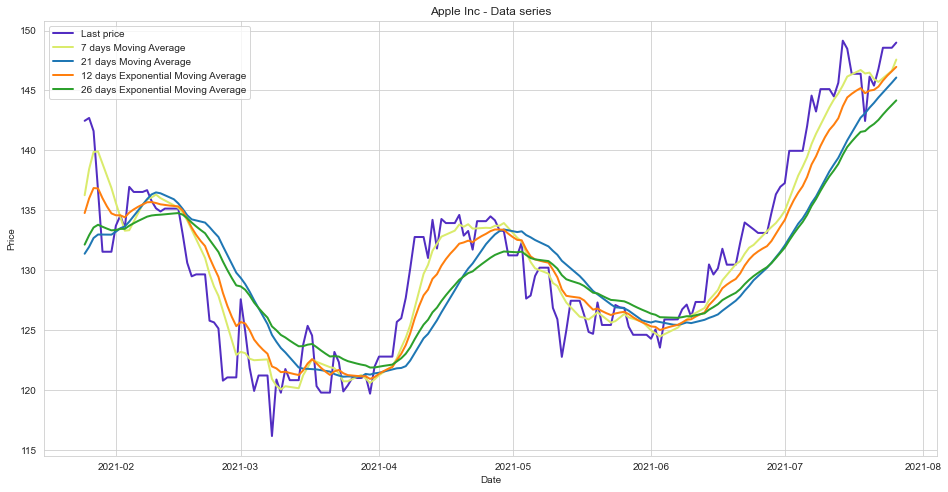

In [11]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(ti_df['PX_LAST'][split_time:], lw=2, c=color1)
plt.plot(ti_df['upper_band'][split_time:], lw=2, c=color2)
plt.plot(ti_df['lower_band'][split_time:], lw=2, c=color3)
plt.legend(['Last price','Upper band', 'Lower band'])
plt.title(dfname + ' - Data series')
plt.grid(True)
plt.show()


plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(ti_df['PX_LAST'][split_time:], lw=2, c=color1)
plt.plot(ti_df['ma7'][split_time:], lw=2, c=color2)
plt.plot(ti_df['ma21'][split_time:], lw=2)
plt.plot(ti_df['12ema'][split_time:], lw=2 )
plt.plot(ti_df['26ema'][split_time:], lw=2)

plt.legend(["Last price","7 days Moving Average","21 days Moving Average","12 days Exponential Moving Average", "26 days Exponential Moving Average"])
plt.title(dfname + ' - Data series')
plt.grid(True)
plt.show()

In [12]:
y_test = scaler.inverse_transform(y_test)
y_test = pd.DataFrame(y_test)

In [13]:
addMetrics(metricsDF, "7 days Moving Average", ti_df['ma7'][split_time:].values.reshape(-1))
addMetrics(metricsDF, "21 days Moving Average", ti_df['ma21'][split_time:].values.reshape(-1))
addMetrics(metricsDF, "12 days Exponential Moving Average", ti_df['12ema'][split_time:].values.reshape(-1))
addMetrics(metricsDF, "26 days Exponential Moving Average", ti_df['26ema'][split_time:].values.reshape(-1))
metricsDF

,MSE,MAE
7 days Moving Average,4.947368,1.698176
21 days Moving Average,20.061326,3.547613
12 days Exponential Moving Average,7.343193,2.128108
26 days Exponential Moving Average,18.753952,3.496719


## LSTM

In [14]:
y_predicted_lstm = model_lstm.predict(X_test)
y_predicted_lstm = scaler.inverse_transform(y_predicted_lstm)
y_predicted_lstm = pd.DataFrame(y_predicted_lstm)

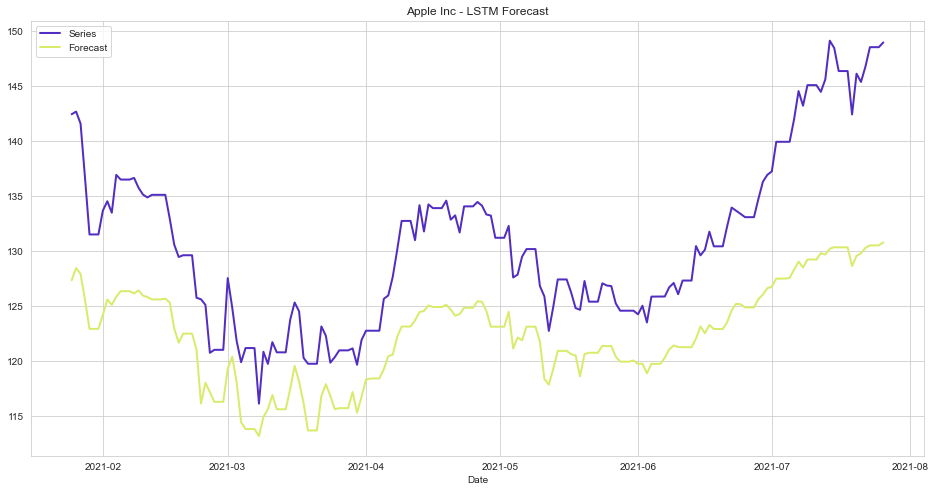

In [15]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.plot(df['PX_LAST'][split_time:], lw=2, c=color1)
plt.plot(df['PX_LAST'][split_time:].index, y_predicted_lstm, lw=2, c=color2)
plt.legend(['Series', 'Forecast'])
plt.title(dfname+' - LSTM Forecast')
plt.grid(True)
plt.show()

In [16]:
addMetrics(metricsDF, "LSTM prediction",y_predicted_lstm.values.reshape(-1))
metricsDF

,MSE,MAE
7 days Moving Average,4.947368,1.698176
21 days Moving Average,20.061326,3.547613
12 days Exponential Moving Average,7.343193,2.128108
26 days Exponential Moving Average,18.753952,3.496719
LSTM prediction,81.724068,8.273955


# GRU

In [17]:
y_predicted_gru = model_gru.predict(X_test)
y_predicted_gru = scaler.inverse_transform(y_predicted_gru)
y_predicted_gru = pd.DataFrame(y_predicted_gru)

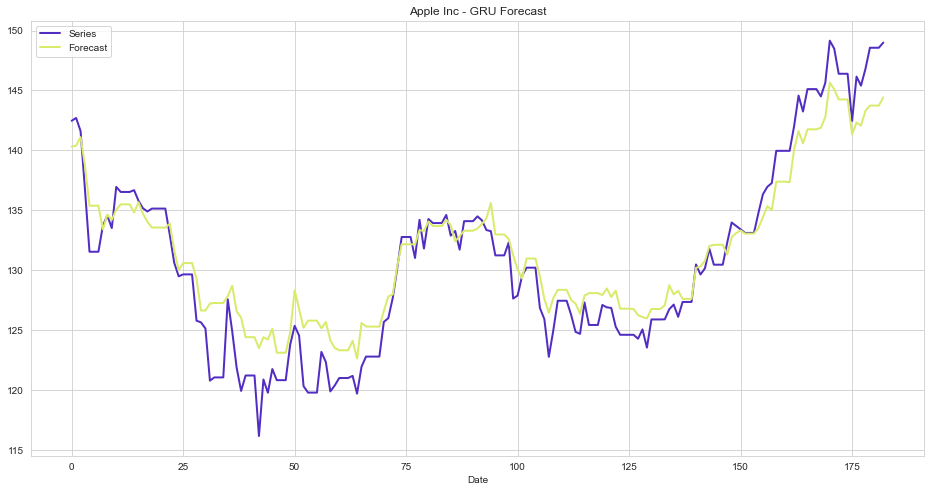

In [18]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.plot(y_test, lw=2, c=color1)
plt.plot(y_test.index, y_predicted_gru, lw=2, c=color2)
plt.legend(['Series', 'Forecast'])
plt.title(dfname+' - GRU Forecast')
plt.grid(True)
plt.show()

In [19]:
addMetrics(metricsDF, "GRU prediction",y_predicted_gru.values.reshape(-1))
metricsDF

,MSE,MAE
7 days Moving Average,4.947368,1.698176
21 days Moving Average,20.061326,3.547613
12 days Exponential Moving Average,7.343193,2.128108
26 days Exponential Moving Average,18.753952,3.496719
LSTM prediction,81.724068,8.273955
GRU prediction,6.538387,2.045626
